In [18]:
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv("data/HW3/fulldataset.csv")
df.head()
data = df[['persontotal','numfatal','cellphoneuse']]
data.corr(method = 'pearson')

,persontotal,numfatal,cellphoneuse
persontotal,1.000000,0.162806,-0.034306
numfatal,0.162806,1.000000,0.021068
cellphoneuse,-0.034306,0.021068,1.000000


In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams

import matplotlib.cm as cm
import matplotlib as mpl
from cycler import cycler
from palettable.colorbrewer.qualitative import Dark2_7


dark2_cmap = Dark2_7
dark2_colors = dark2_cmap.mpl_colors

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.prop_cycle'] = cycler('color',dark2_colors)
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings('ignore', message='Polyfit*')

import random
import copy
def scatter_by(df, scatterx, scattery, by=None, figure=None, axes=None, colorscale=dark2_cmap, labeler={}, mfunc=None, setupfunc=None, mms=8):
    cs=copy.deepcopy(colorscale.mpl_colors)
    if not figure:
        figure=plt.figure(figsize=(8,8))
    if not axes:
        axes=figure.gca()
    x=df[scatterx]
    y=df[scattery]
    if not by:
        col=random.choice(cs)
        axes.scatter(x, y, cmap=colorscale, c=col)
        if setupfunc:
            axeslist=setupfunc(axes, figure)
        else:
            axeslist=[axes]
        if mfunc:
            mfunc(axeslist,x,y,color=col, mms=mms)
    else:
        cs=list(np.linspace(0,1,len(df.groupby(by))))
        xlimsd={}
        ylimsd={}
        xs={}
        ys={}
        cold={}
        for k,g in df.groupby(by):
            col=cs.pop()
            x=g[scatterx]
            y=g[scattery]
            xs[k]=x
            ys[k]=y
            c=colorscale.mpl_colormap(col)
            cold[k]=c
            axes.scatter(x, y, c=c, label=labeler.get(k,k), s=40, alpha=0.3);
            xlimsd[k]=axes.get_xlim()
            ylimsd[k]=axes.get_ylim()
        xlims=[min([xlimsd[k][0] for k in xlimsd.keys()]), max([xlimsd[k][1] for k in xlimsd.keys()])]
        ylims=[min([ylimsd[k][0] for k in ylimsd.keys()]), max([ylimsd[k][1] for k in ylimsd.keys()])]
        axes.set_xlim(xlims)
        axes.set_ylim(ylims)
        if setupfunc:
            axeslist=setupfunc(axes, figure)
        else:
            axeslist=[axes]
        if mfunc:
            for k in xs.keys():
                mfunc(axeslist,xs[k],ys[k],color=cold[k], mms=mms);
    axes.set_xlabel(scatterx);
    axes.set_ylabel(scattery);
    
    return axes

def make_rug(axeslist, x, y, color='b', mms=8):
    axes=axeslist[0]
    zerosx1=np.zeros(len(x))
    zerosx2=np.zeros(len(x))
    xlims=axes.get_xlim()
    ylims=axes.get_ylim()
    zerosx1.fill(ylims[1])
    zerosx2.fill(xlims[1])
    axes.plot(x, zerosx1, marker='|', color=color, ms=mms)
    axes.plot(zerosx2, y, marker='_', color=color, ms=mms)
    axes.set_xlim(xlims)
    axes.set_ylim(ylims)
    return axes

[0.58140289 0.41859711]


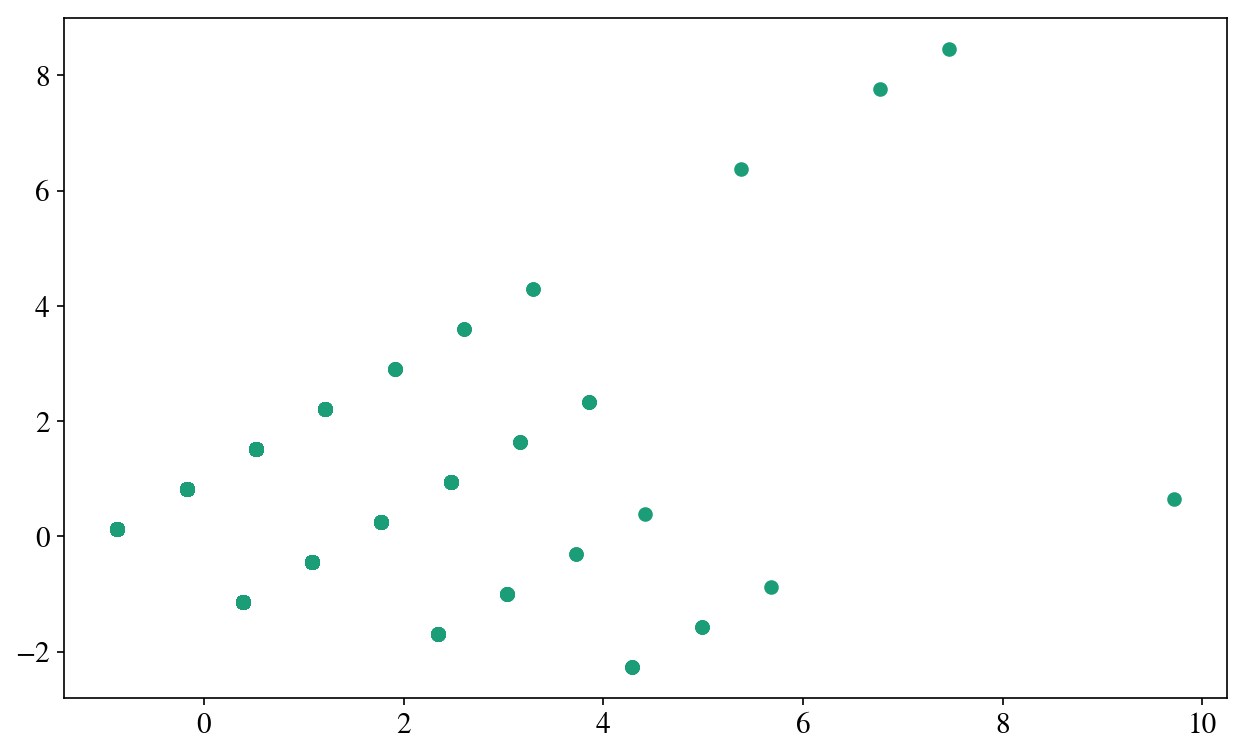

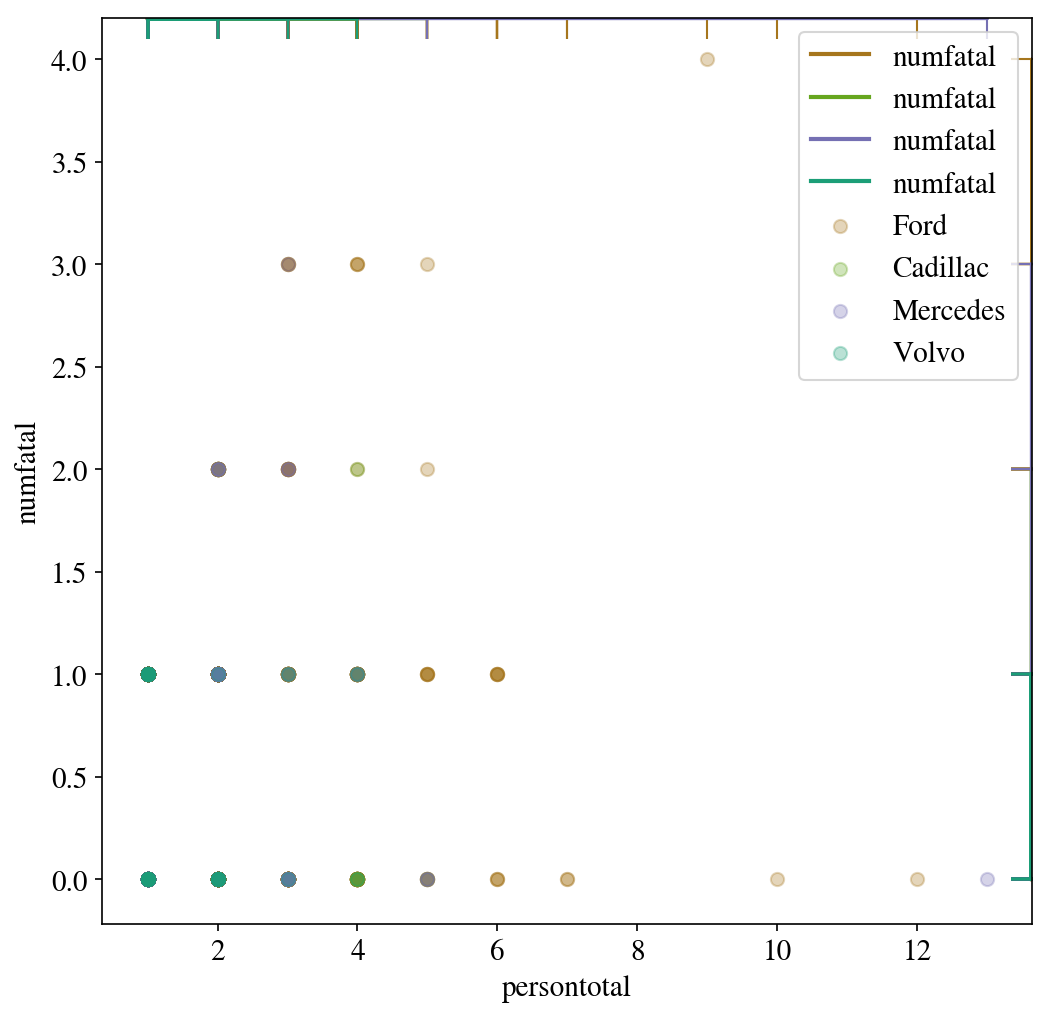

In [19]:
#TASK 6 DECOMPOSITION PCA-2

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

X_HD = data[['persontotal', 'numfatal']].values
X_HDn = (X_HD - X_HD.mean(axis=0))/X_HD.std(axis=0)
person_std_vec = X_HDn[:,0]
person_std = person_std_vec.reshape(-1,1)
numfatal_std_vec = X_HDn[:,1]
numfatal_std = numfatal_std_vec.reshape(-1,1)


pca = PCA(n_components=2)
X = pca.fit_transform(X_HDn)
print (pca.explained_variance_ratio_)
plt.scatter(X[:, 0], X[:, 1])
dkeys=[12,19,42,51]
dvals=['Ford','Cadillac','Mercedes','Volvo']
dmap={e[0]:e[1] for e in zip(dkeys,dvals)}
ax=scatter_by(df, 'persontotal', 'numfatal', by='make', labeler=dmap, mfunc=make_rug, mms=20)
ax.grid(False)
ax.legend(loc='upper right');

In [32]:
#TASK 1 CONCATENATING 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

X = (X_HD - X_HD.mean(axis=0))/X_HD.std(axis=0)
y = df[["make"]].values
y = np.array(y)
y = np.reshape(y,1795)

# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])

param_grid = dict(features__pca__n_components=[1, 2],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

[[ 0.45558826  1.07581797]
 [-0.52614155 -0.70071676]
 [ 1.43731807  2.8523527 ]
 ...
 [-0.52614155 -0.70071676]
 [-0.52614155 -0.70071676]
 [-0.52614155  1.07581797]]
[12 12 12 ... 51 51 51]
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1, score=0.845, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1, score=0.8478260869565217, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=0.1, score=0.847571189279732, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=1 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=1, score=0.845, total=   0.0s
[CV] f

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s


[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=10, score=0.8478260869565217, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=1, svm__C=10 
[CV]  features__pca__n_components=1, features__univ_select__k=1, svm__C=10, score=0.847571189279732, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1, score=0.845, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1, score=0.8478260869565217, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1 
[CV]  features__pca__n_components=1, features__univ_select__k=2, svm__C=0.1, score=0.847571189279732, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=1 
[CV]  features__pca__n_components=1, features__univ_sel

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s remaining:    0.0s


[CV]  features__pca__n_components=1, features__univ_select__k=2, svm__C=10, score=0.845, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=10 
[CV]  features__pca__n_components=1, features__univ_select__k=2, svm__C=10, score=0.8478260869565217, total=   0.0s
[CV] features__pca__n_components=1, features__univ_select__k=2, svm__C=10 
[CV]  features__pca__n_components=1, features__univ_select__k=2, svm__C=10, score=0.847571189279732, total=   0.0s
[CV] features__pca__n_components=2, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=2, features__univ_select__k=1, svm__C=0.1, score=0.845, total=   0.0s
[CV] features__pca__n_components=2, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=2, features__univ_select__k=1, svm__C=0.1, score=0.8478260869565217, total=   0.0s
[CV] features__pca__n_components=2, features__univ_select__k=1, svm__C=0.1 
[CV]  features__pca__n_components=2, features__univ_select__k=1, sv

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    1.3s finished


explained variance ratio (first two components): [0.58140289 0.41859711]


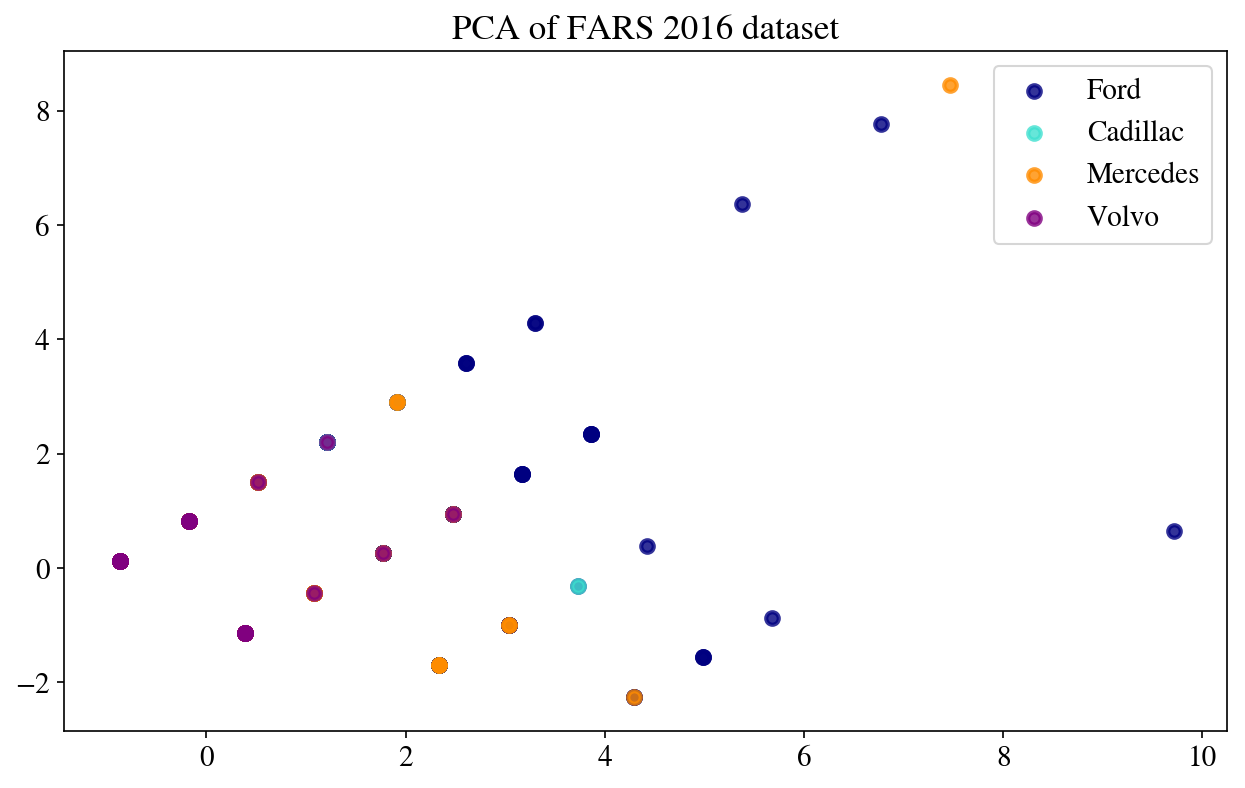

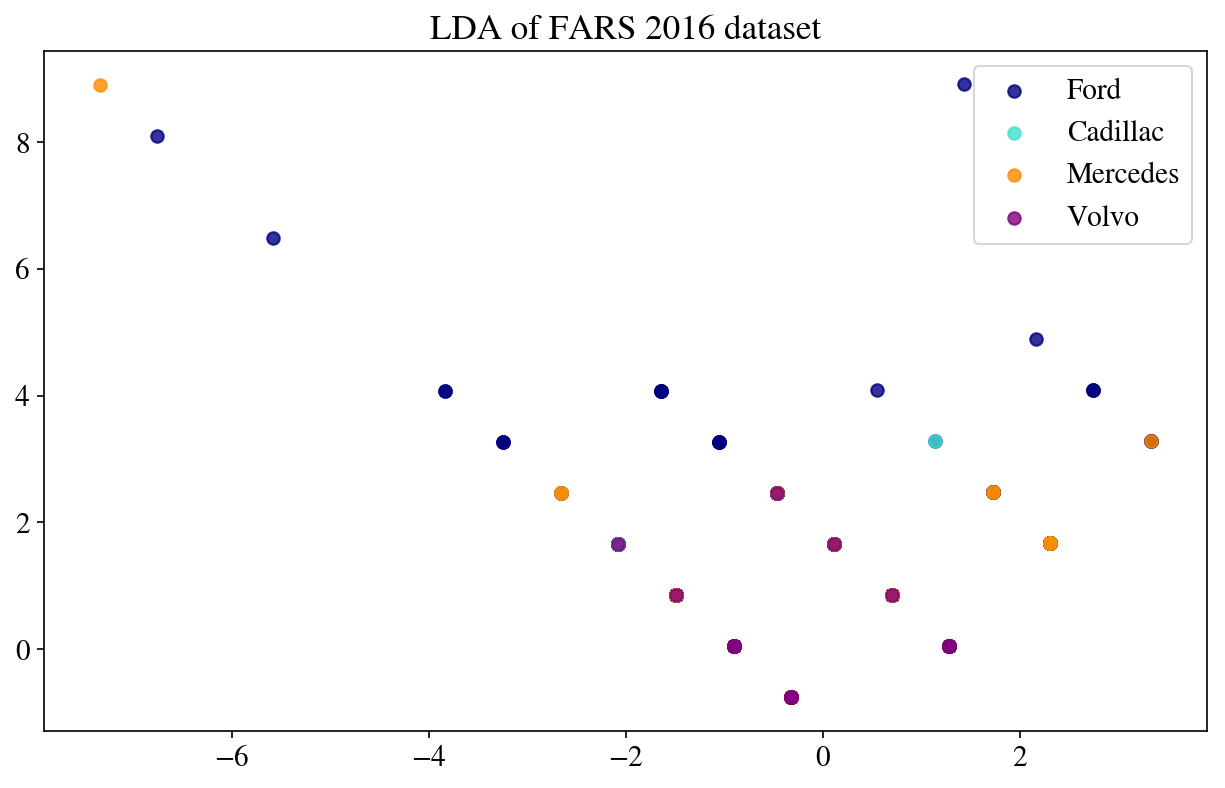

In [36]:
#TASK 7 LDA VS PCA
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



X = (X_HD - X_HD.mean(axis=0))/X_HD.std(axis=0)
y = df[["make"]].values
y = np.array(y)
y = np.reshape(y,1795)
target_names = ['Ford','Cadillac','Mercedes','Volvo']


pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange','purple']
lw = 2

for color, i, target_name in zip(colors, [12, 19, 42,51], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of FARS 2016 dataset')

plt.figure()
for color, i, target_name in zip(colors, [12, 19, 42, 51], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of FARS 2016 dataset')

plt.show()